# GPU Information

In [2]:
! nvidia-smi

Tue Dec  8 03:03:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os




In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Input, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt




In [6]:
!pip install --upgrade tensorflow_federated

!pip install --upgrade nest_asyncio

import nest_asyncio
nest_asyncio.apply()
import tensorflow_federated as tff
import collections
import numpy as np




     |████████████████████████████████| 522kB 8.6MB/s 
     |████████████████████████████████| 3.0MB 12.8MB/s 
     |████████████████████████████████| 174kB 28.4MB/s 
     |████████████████████████████████| 153kB 51.2MB/s 
     |████████████████████████████████| 1.1MB 41.8MB/s 
     |████████████████████████████████| 112kB 66.5MB/s 
  Created wheel for absl-py: filename=absl_py-0.9.0-cp36-none-any.whl size=121933 sha256=8e7dd962e8e26cd856cb7354763c0eef049daa6d69c03287940140c4e125464b
  Stored in directory: /root/.cache/pip/wheels/8e/28/49/fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
Successfully built absl-py
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33.2:
      Successfully uninstalled grpcio-1.33.2
  Found existing installation: attrs 20.3.0
    Uninstalling attrs-20.3.0:
      Successfully uninstalled attrs-20.3.0
  Found existing installati

Requirement already up-to-date: nest_asyncio in /usr/local/lib/python3.6/dist-packages (1.4.3)


In [7]:
from tensorflow import reshape, nest, config
from tensorflow.keras import losses, metrics, optimizers
import pickle

In [8]:
import time

In [17]:
with open("/content/drive/MyDrive/x_train2243.pkl", 'rb') as f:
     x_train= pickle.load(f)

In [18]:
with open("/content/drive/MyDrive/y_train2243.pkl", 'rb') as f:
     y_train= pickle.load(f)

In [19]:
with open("/content/drive/MyDrive/x_test2243.pkl", 'rb') as f:
     x_test= pickle.load(f)

In [20]:
with open("/content/drive/MyDrive/y_test2243.pkl", 'rb') as f:
     y_test= pickle.load(f)

In [21]:
#print(len(y_test))

In [22]:
print(x_train[1].shape)

(224, 224, 3)


In [23]:
# x_test= x_train[:500]
# y_test= y_train[:500]

In [24]:
print(len(y_test))

624


In [25]:
x_test = np.array(x_test, dtype=np.float32).reshape(624, 224, 224, 3)
y_test = np.array(y_test, dtype=np.int32).reshape(624, 1)

In [26]:
experiment_name = "DenseNet121"
method = "tff_training"
client_lr = 0.2   #Rmsprop
server_lr = 1.0   #Rmsprop
split = 2
NUM_ROUNDS = 21
NUM_EPOCHS = 5
BATCH_SIZE = 32
PREFETCH_BUFFER = 10

In [27]:
total_image_count = len(x_train)
image_per_set = int(np.floor(total_image_count/split))

client_train_dataset = collections.OrderedDict()
for i in range(1, split+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train[start:end]), ('pixels', x_train[start:end])))
    client_train_dataset[client_name] = data

Adding data from 0 to 2613 for client : client_1
Adding data from 2613 to 5226 for client : client_2


In [28]:
# total_image_count = len(x_test)
# image_per_set = int(np.floor(total_image_count/split))

# client_test_dataset = collections.OrderedDict()
# for i in range(1, split+1):
#     client_name = "client_" + str(i)
#     start = image_per_set * (i-1)
#     end = image_per_set * i

#     print(f"Adding data from {start} to {end} for client : {client_name}")
#     data = collections.OrderedDict((('label', y_test[start:end]), ('pixels', x_test[start:end])))
#     client_test_dataset[client_name] = data

In [29]:
train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)
#test_dataset = tff.simulation.FromTensorSlicesClientData(client_test_dataset)
sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])
sample_element = next(iter(sample_dataset))



In [30]:
SHUFFLE_BUFFER = image_per_set

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""

    return collections.OrderedDict(
        x=reshape(element['pixels'], [-1, 224, 224, 3]),
        y=reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)



In [31]:
preprocessed_sample_dataset = preprocess(sample_dataset)
sample_batch = nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))
sample_batch

OrderedDict([('x', array([[[[0.07450981, 0.07450981, 0.07450981],
                       [0.09019608, 0.09019608, 0.09019608],
                       [0.10588235, 0.10588235, 0.10588235],
                       ...,
                       [0.        , 0.        , 0.        ],
                       [0.        , 0.        , 0.        ],
                       [0.        , 0.        , 0.        ]],
              
                      [[0.07450981, 0.07450981, 0.07450981],
                       [0.09019608, 0.09019608, 0.09019608],
                       [0.10588235, 0.10588235, 0.10588235],
                       ...,
                       [0.        , 0.        , 0.        ],
                       [0.        , 0.        , 0.        ],
                       [0.        , 0.        , 0.        ]],
              
                      [[0.07058824, 0.07058824, 0.07058824],
                       [0.08627451, 0.08627451, 0.08627451],
                       [0.10196079, 0.10196079, 0.101

In [32]:
def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

federated_train_data = make_federated_data(train_dataset, train_dataset.client_ids)
#federated_test_data = make_federated_data(test_dataset, test_dataset.client_ids)
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))



Number of client datasets: 2
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 224, 224, 3)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [33]:
# def create_keras_model():

#   # create the base pre-trained model
#   base_model = InceptionV3(weights=None, include_top=False , input_shape=(224, 224, 3))
#   x = base_model.output
#   # x = Dropout(0.5)(x)
#   x = GlobalAveragePooling2D()(x)
#   x = Dense(128, activation='relu')(x)
#   x = BatchNormalization()(x)
#   predictions = Dense(1, activation='sigmoid')(x)
#   model = Model(inputs=base_model.input, outputs=predictions)
#   return model

In [34]:
def create_keras_model(image_size = 224, load_previous_weights = False, freeze_cnn = False):
    base_model = DenseNet121(include_top= False, input_shape=(image_size,image_size,3), weights="imagenet")

   
    x = base_model.output
    x = GlobalAveragePooling2D(input_shape=(1024,1,1))(x) 
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)  
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)

  
    return model

In [36]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.Accuracy()])



In [37]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))



29089792/29084464 [==============================] - 0s 0us/step
( -> <model=<trainable=<float32[7,7,3,64],float32[64],float32[64],float32[64],float32[64],float32[1,1,64,128],float32[128],float32[128],float32[3,3,128,32],float32[96],float32[96],float32[1,1,96,128],float32[128],float32[128],float32[3,3,128,32],float32[128],float32[128],float32[1,1,128,128],float32[128],float32[128],float32[3,3,128,32],float32[160],float32[160],float32[1,1,160,128],float32[128],float32[128],float32[3,3,128,32],float32[192],float32[192],float32[1,1,192,128],float32[128],float32[128],float32[3,3,128,32],float32[224],float32[224],float32[1,1,224,128],float32[128],float32[128],float32[3,3,128,32],float32[256],float32[256],float32[1,1,256,128],float32[128],float32[128],float32[1,1,128,128],float32[128],float32[128],float32[3,3,128,32],float32[160],float32[160],float32[1,1,160,128],float32[128],float32[128],float32[3,3,128,32],float32[192],float32[192],float32[1,1,192,128],float32[128],float32[128],float32[3,3

In [38]:
!rm -R /tmp/logs/scalars/*

rm: cannot remove '/tmp/logs/scalars/*': No such file or directory


In [39]:
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)

In [40]:
# evaluation = tff.learning.build_federated_evaluation(model_fn)

In [41]:
tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []


In [42]:
def keras_evaluate(state, round_num):
  # Take our global model weights and push them back into a Keras model to
  # use its standard `.evaluate()` method.
  keras_model = create_keras_model()
  keras_model.compile(
      loss=losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.Accuracy()])
  state.model.assign_weights_to(keras_model)
  loss, accuracy = keras_model.evaluate(x=x_test,y=y_test, verbose=0)
  tff_val_acc.append(accuracy)
  tff_val_loss.append(loss)
  print('\tEval: loss={l:.3f}, accuracy={a:.3f}'.format(l=loss, a=accuracy))


In [42]:
state = iterative_process.initialize()
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    t1 = time.time()
    state, metrics = iterative_process.next(state, federated_train_data)
    t2 = time.time()
    print('round {:2d}, metrics={},round time {t:.2f} seconds'.format(round_num, metrics,t=t2 - t1))
    tff_train_acc.append(float(metrics['train']['accuracy']))
    tff_train_loss.append(float(metrics['train']['loss']))
    #keras_evaluate(state, round_num)
    for name, value in metrics['train'].items():
      tf.summary.scalar(name, value, step=round_num)

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('accuracy', 0.053960964), ('loss', 2.5777788)]))]),round time 344.94 seconds
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('accuracy', 0.7255645), ('loss', 2.184331)]))]),round time 236.56 seconds
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('accuracy', 0.19115959), ('loss', 1.1357597)]))]),round time 235.98 seconds
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('accuracy', 0.23895904), ('loss', 0.9595516)]))]),round time 235.51 seconds
round  5, metrics=OrderedDict([('broadcast', ()), ('a

In [ ]:
# for round_num in range(11, 21):
#     state, metrics = iterative_process.next(state, federated_train_data)
#     #test_metrics = evaluation(state.model, federated_test_data)
#     #print(test_metrics)
#     keras_evaluate(state, round_num)
#     print('round {:2d}, metrics={}'.format(round_num, metrics))
#     for name, value in metrics['train'].items():
#       tf.summary.scalar(name, value, step=round_num)

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [49]:
keras_model = create_keras_model()
keras_model.compile(
    loss=losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy()])
state.model.assign_weights_to(keras_model)

In [ ]:
predicted = keras_model.predict(x_test)
report = confusion_matrix(y_test, predicted)
print(report)
print(classification_report(y_test,predicted))

In [ ]:
output_dir="/content/drive/MyDrive/"

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']

In [ ]:
report = pd.DataFrame(report , index = ['0','1'] , columns = ['0','1'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(report,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [43]:
output_dir="/content/drive/MyDrive/"

In [45]:
from matplotlib import pyplot as plt


def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)

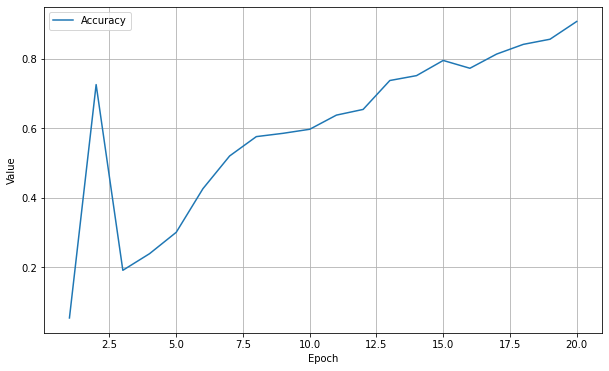

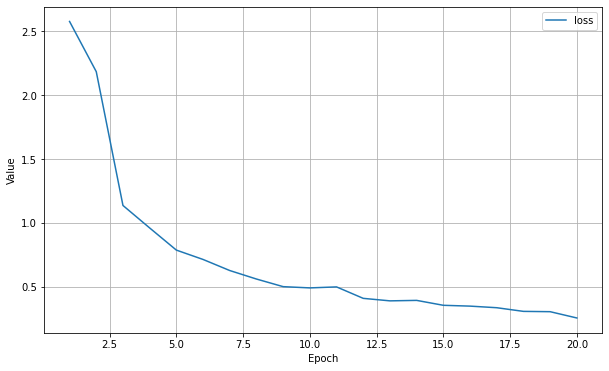

In [48]:
fig = plt.figure(figsize=(10, 6))
#plot_graph(list(range(len(tff_train_acc))), tff_train_acc, label='Accuracy')
plot_graph([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], tff_train_acc, label='Accuracy')
#plot_graph(list(range(len(tff_val_acc))), tff_val_acc, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir+"federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], tff_train_loss, label='loss')
#plot_graph(list(range(len(tff_val_loss))), tff_val_loss, label='Validation loss')
plt.legend()
plt.savefig(output_dir+"federated_model_loss.png")

# Memory Information

In [ ]:
"""state = iterative_process.initialize()
NUM_ROUNDS = 11
for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    
    print('round {:2d}, metrics={}'.format(round_num, metrics))
   # print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")"""

In [ ]:
#%load_ext tensorboard

In [ ]:
# !ls {logdir}
# %tensorboard --logdir {logdir} --port=2

In [ ]:
# keras_model1 = create_keras_model()

In [ ]:
# keras_model1.compile( loss=losses.BinaryCrossentropy(),
      # metrics=[tf.keras.metrics.Accuracy()])

In [ ]:
# testdata = collections.OrderedDict((('label', y_test), ('pixels', x_test)))

In [ ]:
# preptest = preprocess(testdata)

In [ ]:
# print(y_test)

In [ ]:
# x_test = np.array(x_test, dtype=np.float32).reshape(624, 224, 224, 3)
# y_test = np.array(y_test, dtype=np.int32).reshape(624, 1)

In [ ]:
# state.model.assign_weights_to(keras_model1)
# loss, accuracy = keras_model1.evaluate(x_test, y_test, verbose=0)
# print('\tEval: loss={l:.3f}, accuracy={a:.3f}'.format(l=loss, a=accuracy))